In [ ]:
import os
import gdown
import zipfile
from tqdm import tqdm

In [ ]:
def download_file_from_google_drive(file_url, destination):
    gdown.download(file_url, destination, quiet=False)

# Definisi link Google Drive dataset
file_url = 'https://drive.google.com/uc?id=1j3NCboyzjHCv2Lu1pZqF39ZfIKET7bMF'
destination = '/content/Dataset.zip'

# Unduh dataset dari Google Drive
download_file_from_google_drive(file_url, destination)

# Ekstrak file zip dataset
extract_path = '/content/Dataset'
with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset telah diunduh dan diekstrak.")

Downloading...
From (original): https://drive.google.com/uc?id=1j3NCboyzjHCv2Lu1pZqF39ZfIKET7bMF
From (redirected): https://drive.google.com/uc?id=1j3NCboyzjHCv2Lu1pZqF39ZfIKET7bMF&confirm=t&uuid=e8233a72-5969-4b53-855a-c05392be15f6
To: /content/Dataset.zip
100%|██████████| 223M/223M [00:02<00:00, 90.6MB/s]


Dataset telah diunduh dan diekstrak.


## Visualization

In [ ]:
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm

# Definisikan path untuk train
train_path = '/content/Dataset/Dataset/Train'
test_path = '/content/Dataset/Dataset/Test'

x_data = []
y_data = []

# Loop melalui setiap kategori (Recyclable dan Organic)
for category in glob(train_path + '/*'):
    # Ambil nama kategori dari path
    category_name = os.path.basename(category)
    print("Exploring category:", category_name)

    # Loop melalui setiap file dalam kategori
    for file in tqdm(glob(category + '/*')):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

        # Simpan gambar dan label ke dalam list
        x_data.append(img_array)
        y_data.append(category_name)

# Buat DataFrame dari data yang telah diambil
data = pd.DataFrame({'image': x_data, 'label': y_data})


Exploring category: Recyclable


100%|██████████| 9999/9999 [00:09<00:00, 1007.71it/s]


Exploring category: Organic


100%|██████████| 12565/12565 [00:13<00:00, 958.45it/s] 


In [ ]:
print(data.shape)

(22564, 2)


In [ ]:
from collections import Counter
Counter(y_data)

Counter({'Recyclable': 9999, 'Organic': 12565})

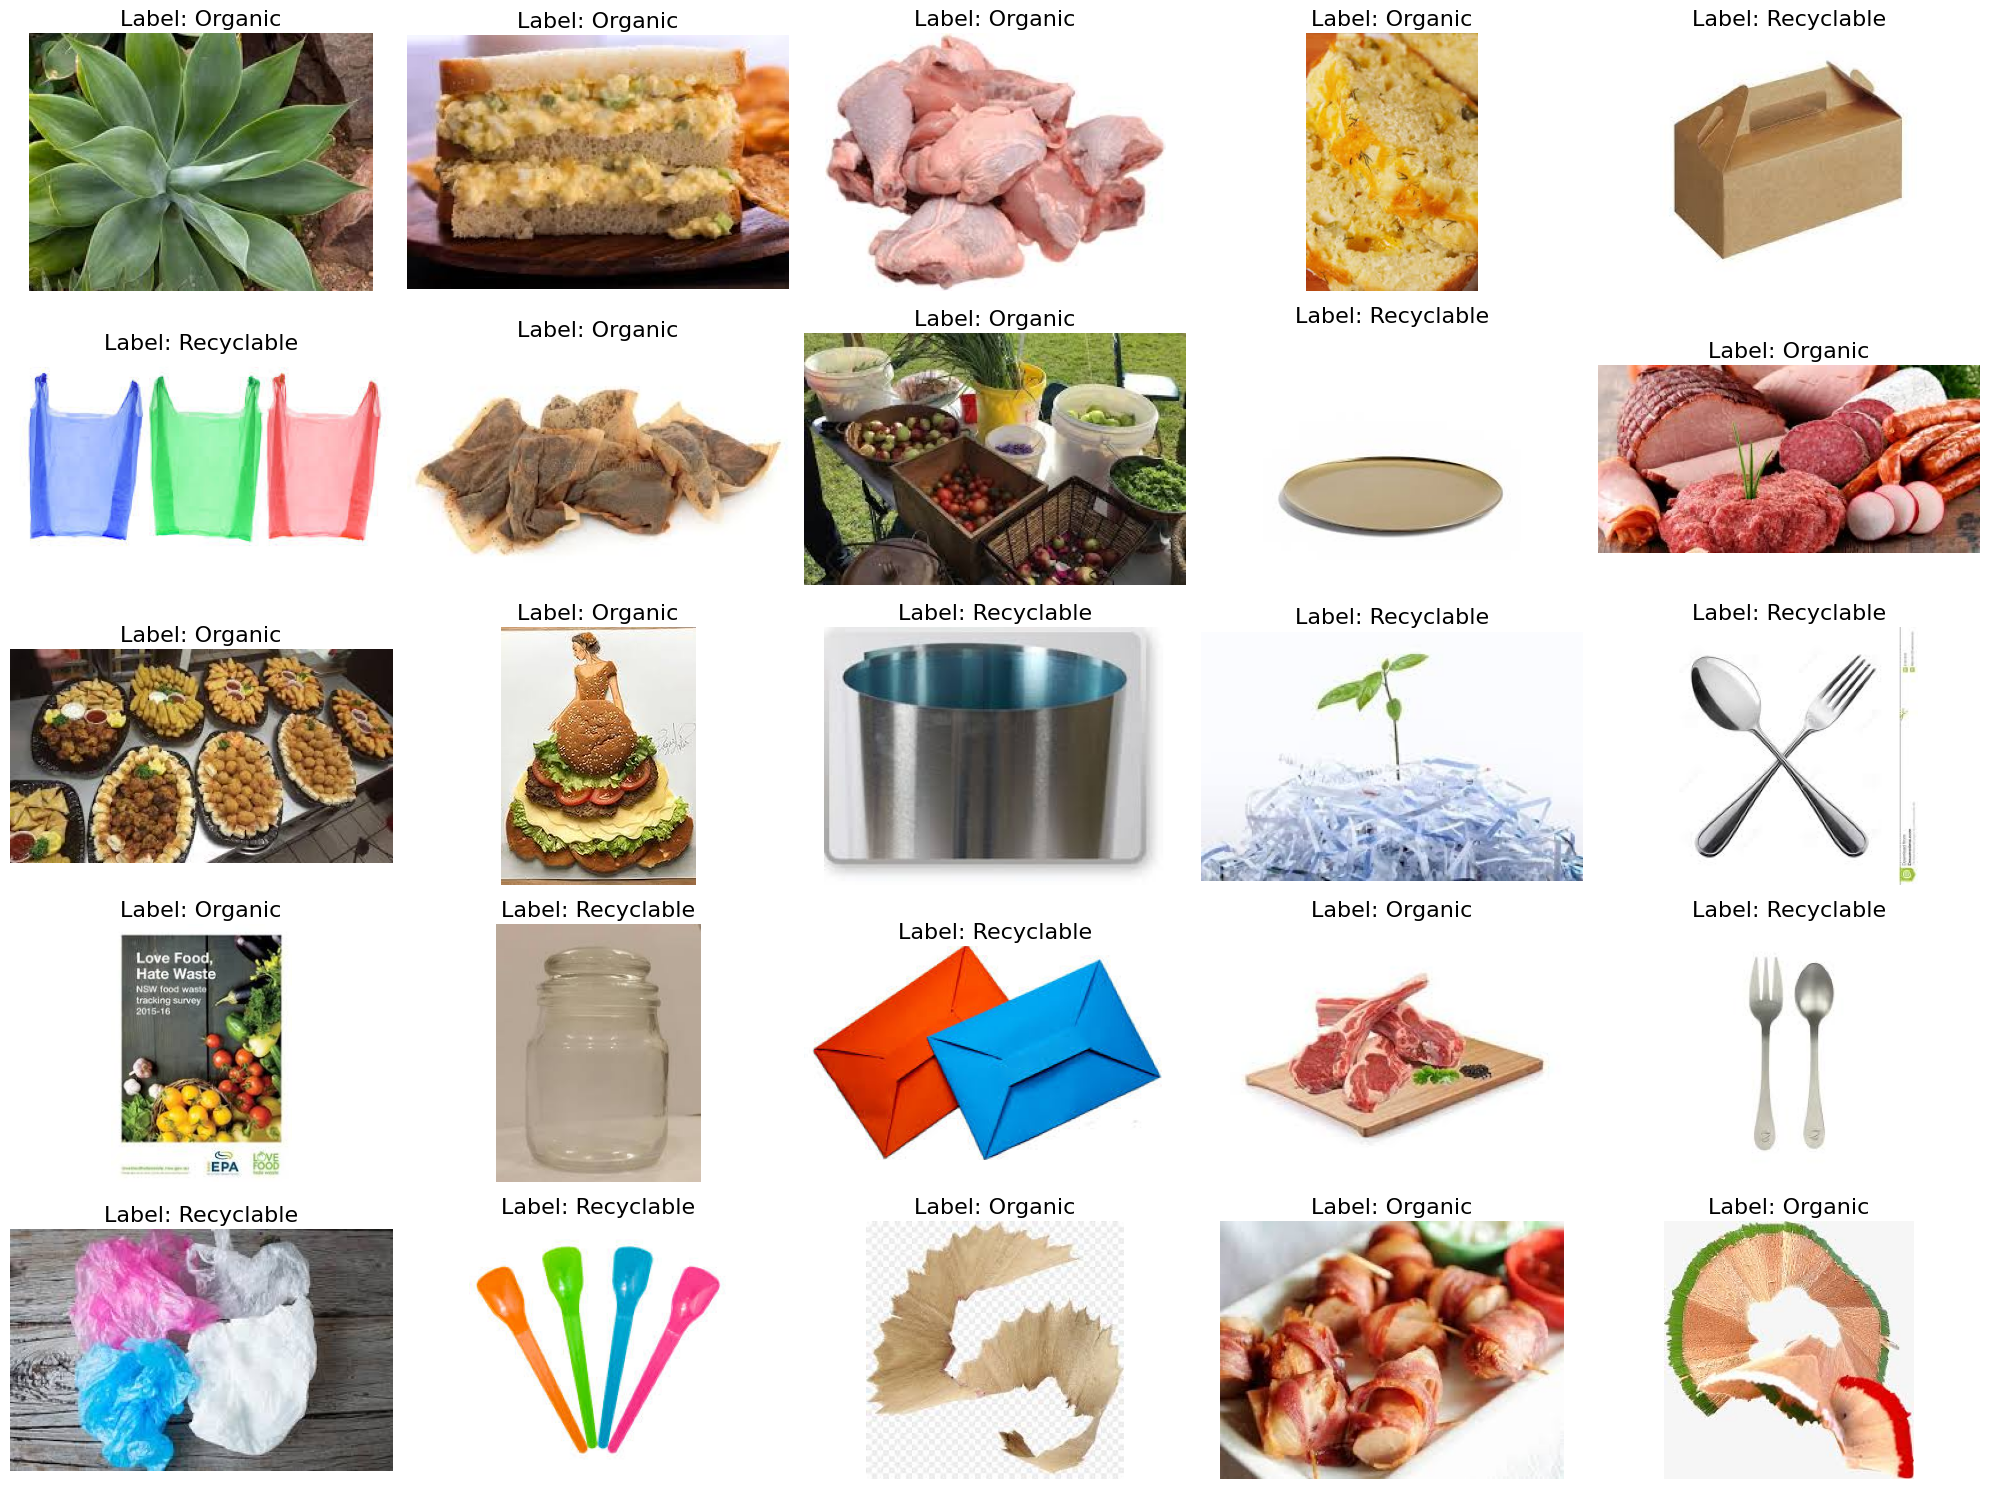

In [ ]:
import numpy as np

plt.figure(figsize=(20, 15))
for i in range(25):
    plt.subplot(5, 5, i+1)
    index = np.random.randint(len(data))
    plt.title('Label: {}'.format(data.label[index]), fontsize=16)
    plt.imshow(data.image[index])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  2


In [ ]:
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.85 and logs.get('val_accuracy') > 0.85:
            print("\nUdah lah, cukup, kasihanilah laptop saya !!!")
            self.model.stop_training = True

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(numberOfClass, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 256


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale= 1./255)
test_datagen = ImageDataGenerator(rescale= 1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [ ]:
model.fit_generator(
    generator = train_generator,
    epochs=10,
    validation_data = test_generator,
    callbacks=[myCallback()]
    )

<ipython-input-19-bb4ef56d6ded>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/10
89/89 [==============================] - 2357s 26s/step - loss: 0.4973 - accuracy: 0.7847 - val_loss: 0.3621 - val_accuracy: 0.8595
Epoch 2/10
89/89 [==============================] - 2341s 26s/step - loss: 0.4017 - accuracy: 0.8358 - val_loss: 0.2968 - val_accuracy: 0.8922
Epoch 3/10
89/89 [==============================] - ETA: 0s - loss: 0.3583 - accuracy: 0.8570 
Udah lah, cukup, kasihanilah laptop saya !!!
89/89 [==============================] - 2333s 26s/step - loss: 0.3583 - accuracy: 0.8570 - val_loss: 0.2975 - val_accuracy: 0.8782


In [20]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [22]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [23]:
print("Evaluating model...")
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

Evaluating model...
10/10 [==============================] - 92s 9s/step - loss: 0.2975 - accuracy: 0.8782
Test accuracy: 0.8782331943511963


Saving biological99.jpg to biological99 (1).jpg
1/1 [==============================] - 0s 52ms/step


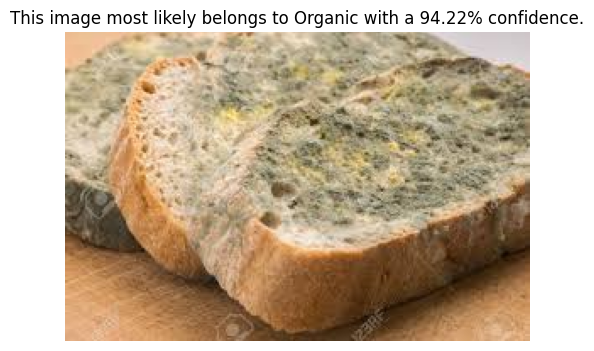

In [44]:
from google.colab import files
from tensorflow.keras.preprocessing import image
def upload_and_predict_image():
    uploaded = files.upload()
    for fn in uploaded.keys():
        path = '/content/' + fn
        img = image.load_img(path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        prediction = model.predict(img_array)

        class_names = list(train_generator.class_indices.keys())  # Mengambil nama kelas dari generator

        predicted_class = class_names[np.argmax(prediction)]
        confidence = 100 * np.max(prediction)

        plt.figure(figsize=(6, 6))
        plt.imshow(image.load_img(path))
        plt.title(f'This image most likely belongs to {predicted_class} with a {confidence:.2f}% confidence.')
        plt.axis('off')
        plt.show()

# Panggil fungsi upload dan prediksi
upload_and_predict_image()


Saving biological99.jpg to biological99 (2).jpg


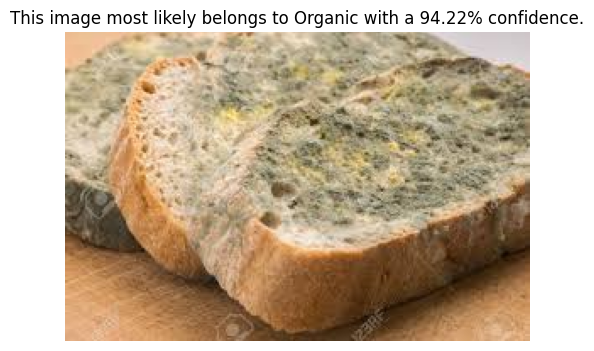

In [45]:
def load_tflite_model(tflite_model_path):
    # Muat model TFLite
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    return interpreter

def predict_image(interpreter, img_array):
    # Dapatkan informasi tentang input dan output tensor
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Siapkan input tensor
    interpreter.set_tensor(input_details[0]['index'], img_array)

    # Jalankan inferensi
    interpreter.invoke()

    # Dapatkan hasil prediksi
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

def upload_and_predict_image_tflite(interpreter):
    uploaded = files.upload()
    for fn in uploaded.keys():
        path = '/content/' + fn
        img = image.load_img(path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        prediction = predict_image(interpreter, img_array)

        class_names = list(train_generator.class_indices.keys())  # Mengambil nama kelas dari generator

        predicted_class = class_names[np.argmax(prediction)]
        confidence = 100 * np.max(prediction)

        plt.figure(figsize=(6, 6))
        plt.imshow(image.load_img(path))
        plt.title(f'This image most likely belongs to {predicted_class} with a {confidence:.2f}% confidence.')
        plt.axis('off')
        plt.show()

# Muat model TFLite
interpreter = load_tflite_model('/content/model.tflite')

# Panggil fungsi upload dan prediksi
upload_and_predict_image_tflite(interpreter)